In [1]:
import torch
from spatial_correlation_sampler import SpatialCorrelationSampler, spatial_correlation_sample
from dl_toolbox.modules import FeatureExtractor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = FeatureExtractor('vit_small_patch14_dinov2').to(device)
feature_extractor.encoder.prune_intermediate_layers(11,prune_norm=True,prune_head=False)

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [6]:
from PIL import Image
import torchvision.transforms.v2 as v2

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

def read_img(path, size, mean, std):
    pil_image = Image.open(path).convert('RGB')
    if size is not None:
        pil_image = v2.Resize((size, size))(pil_image)
    prep = v2.Compose([
        v2.ToTensor(),
        v2.Normalize(mean=mean, std=std)
    ])
    prep_img = prep(pil_image)[None, ...]
    return prep_img, pil_image

In [74]:
image_batch_a, image_pil_a = read_img(
    './dl_toolbox/ranger/dino-vit-features/images/cat.jpg', 672, imagenet_mean, imagenet_std
)
descriptors_1 = feature_extractor(image_batch_a.to(device))[:,1:].view(1,48,48,384).permute(0,3,1,2)
image_batch_b, image_pil_b = read_img(
    './dl_toolbox/ranger/dino-vit-features/images/ibex.jpg', 672, imagenet_mean, imagenet_std
)
descriptors_2 = feature_extractor(image_batch_b.to(device))[:,1:].view(1,48,48,384).permute(0,3,1,2)

In [75]:
# k = 0, d = 20, s1 = 1, s2 = 2
out = spatial_correlation_sample(
    descriptors_1.contiguous(),
    descriptors_2.contiguous(),
    kernel_size=3,
    patch_size=8,
    stride=1,
    padding=0,
    dilation=1,
    dilation_patch=1
)
out.shape

torch.Size([1, 8, 8, 46, 46])

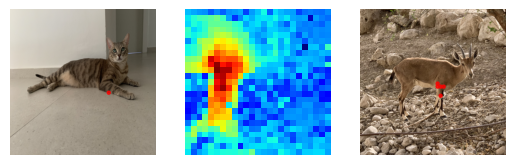

In [77]:
import matplotlib.pyplot as plt 

patch_size = 14
stride = feature_extractor.encoder.patch_embed.proj.stride[0]
load_size_a = (224, 224)
load_size_b = (224, 224)
num_sim_patches = 5
correl_patch_size = 25

# plot
fig, axes = plt.subplots(1, 3)
[axi.set_axis_off() for axi in axes.ravel()]
visible_patches = []
radius = patch_size // 2
# plot image_a and the chosen patch. if nothing marked chosen patch is cls patch.
axes[0].imshow(image_pil_a)

y_coor, x_coor = 390,460
new_H = patch_size / stride * (load_size_a[0] // patch_size - 1) + 1
new_W = patch_size / stride * (load_size_a[1] // patch_size - 1) + 1
y_descs_coor = int(new_H / load_size_a[0] * y_coor)
x_descs_coor = int(new_W / load_size_a[1] * x_coor)

# draw chosen point
center = ((x_descs_coor - 1) * stride + stride + patch_size // 2 - .5,
          (y_descs_coor - 1) * stride + stride + patch_size // 2 - .5)
patch = plt.Circle(center, radius, color=(1, 0, 0, 0.75))
axes[0].add_patch(patch)

# get and draw current similarities
#raveled_desc_idx = num_patches_a[1] * y_descs_coor + x_descs_coor
#reveled_desc_idx_including_cls = raveled_desc_idx + 1

# calculate and plot similarity between image1 and image2 descriptors
#similarities = chunk_cosine_sim(descs_a, descs_b)
#curr_similarities = similarities[0, 0, reveled_desc_idx_including_cls, 1:]
#curr_similarities = curr_similarities.reshape(num_patches_b)
with torch.no_grad():
    similarities = spatial_correlation_sample(
        descriptors_1.contiguous(),
        descriptors_2.contiguous(),
        kernel_size=1,
        patch_size=correl_patch_size,
        stride=1,
        padding=0,
        dilation=1,
        dilation_patch=1
    )
curr_similarities = similarities[0, :, :, y_descs_coor, x_descs_coor]
axes[1].imshow(curr_similarities.cpu().numpy(), cmap='jet')

# get and draw most similar points
axes[2].imshow(image_pil_b)
sims, idxs = torch.topk(curr_similarities.flatten(), num_sim_patches)
h_idxs, w_idxs = torch.unravel_index(idxs, curr_similarities.shape)
for h, w in zip(h_idxs, w_idxs):
    #y_descs_coor, x_descs_coor = idx // num_patches_b[1], idx % num_patches_b[1]
    #y_descs_coor, x_descs_coor = h, w
    h = y_descs_coor + (h - (correl_patch_size-1)/2)
    w = x_descs_coor + (w - (correl_patch_size-1)/2)
    center = ((w - 1) * stride + stride + patch_size // 2 - .5,
              (h - 1) * stride + stride + patch_size // 2 - .5)
    patch = plt.Circle(center, radius, color=(1, 0, 0, 0.75))
    axes[2].add_patch(patch)
plt.draw()